In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [2]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [3]:
from pandas import read_csv, DataFrame
data = read_csv(DATA_DIR/'sample_summary.csv')

training_data = np.load(DATA_DIR/'Dataset #0/training_data.npy')
test_data = np.load(DATA_DIR/'Dataset #0/test_data.npy')
training_label = np.load(DATA_DIR/'Dataset #0/training_label.npy')
test_label = np.load(DATA_DIR/'Dataset #0/test_label.npy')

In [4]:
import dill
import json

with open(DATA_DIR/"setting.json", 'r') as fp:
    _setting = json.load(fp)
_setting_save = _setting["Saving results"]
_setting_data = _setting["Data set selection"]
_setting_qasvm = _setting["SoftQASVM setting"]
_setting_simulator = _setting["Simulator setting"]
_setting_optimizer = _setting["Optimizer setting"]
_setting_rep = _setting["Repetition setting"]

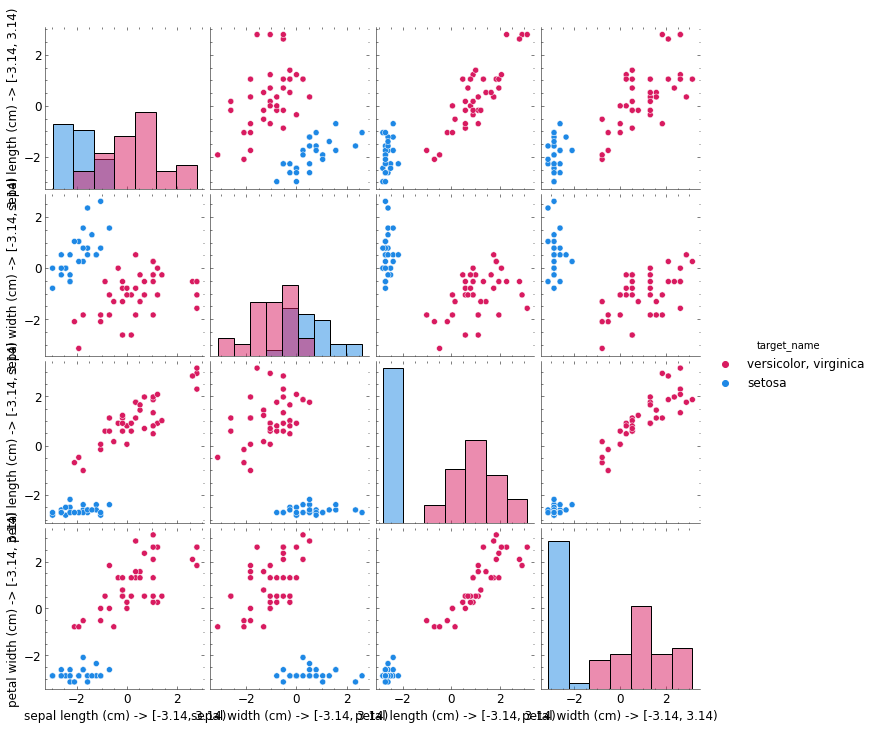

In [100]:
from classifiers.datasets import SklearnDataset

with plt.rc_context({'figure.figsize':(5, 5)}):
    ds = SklearnDataset('iris', (-np.pi, np.pi), true_hot=_setting_data['DATA_HOT'])
    ax = ds.plot(ds.sample_training_and_test_dataset((len(training_label), len(test_label)), return_X_y=False, random_state=_setting_rep["SEED"])[0])

In [6]:
C = _setting_qasvm["C"]
lamda = _setting_qasvm["LAMBDA"]

In [7]:
def fval(did, cid, layer, reps):
    with open(DATA_DIR/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

with open(DATA_DIR/f"Dataset #{0}/Circuit #{1}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm = dill.load(fp)

training_kernel = _qasvm.kernel_matrix
test_kernel = _qasvm._qk.evaluate(test_data, training_data)

In [8]:
from classifiers.convex.svm import CvxSoftQASVM

svm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm.fit(training_kernel, training_label)
true_f = svm.f(test_kernel)

In [9]:
true_f/svm.dual_objective_value

array([-1.71863964,  1.44275466,  0.28501306, -1.34510757, -0.65051514,
        1.44581378,  0.95282077, -1.03690923, -1.48022794,  1.42900574,
       -1.01704132,  1.45912581,  1.23760636, -0.97994223, -0.94662674,
       -0.93704359,  0.67204413,  1.52611633, -0.83622271,  0.52000391,
        0.89818893, -0.98239938, -1.83931408, -1.21963814,  0.95787601,
       -1.20529427,  0.31442975, -1.36661969, -1.29120193, -1.15022843,
       -2.08461567, -1.49945339,  0.55816311, -0.98600805, -1.5787779 ,
        1.20886462, -1.13503567, -1.31215491, -1.50657226, -0.90413313,
        1.11655888,  1.75556601, -1.24821198, -1.65270377, -0.15818415,
       -1.05143245, -1.39630562, -0.67917104, -1.17267427,  1.66417491,
       -1.38464593, -1.56233633,  1.73634432, -1.95764729, -1.10938156,
       -1.26160495,  0.99776421,  0.87903596,  1.11342278, -1.15181474,
        1.48005058, -0.98375861, -1.42659359,  1.70919593, -1.14460831,
       -1.41229818,  1.0777566 , -1.09634924, -1.83931408, -0.20

In [10]:
def fval_error(*args):
    return np.mean(np.abs(fval(*args)-true_f))# /sum(np.abs(true_f))

from itertools import product
from pandas import DataFrame

fval_error_ = {}
for _ind, _exp in enumerate(data.iloc):
    fval_error_[_ind] = fval_error(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data = data.to_dict()
new_data['ferror'] = fval_error_
data = DataFrame(new_data)

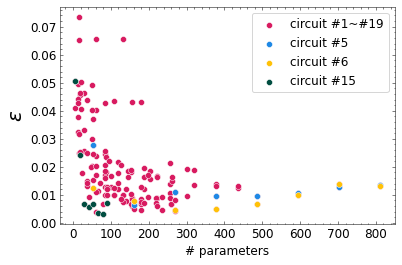

In [112]:
import seaborn as sns

sns.scatterplot(data=data, x='num_params', y='ferror', label='circuit #1~#19')
sns.scatterplot(data=data.loc[data['circuit_id']==5], x='num_params', y='ferror', label='circuit #5')
sns.scatterplot(data=data.loc[data['circuit_id']==6], x='num_params', y='ferror', label='circuit #6')
sns.scatterplot(data=data.loc[data['circuit_id']==15], x='num_params', y='ferror', label='circuit #15')

# plt.xscale('log')
plt.xlabel('# parameters')
plt.ylabel(r'$\epsilon$', fontsize=20)
plt.legend()
plt.savefig('./figs/si_sum_epsilon_num_params.pdf')

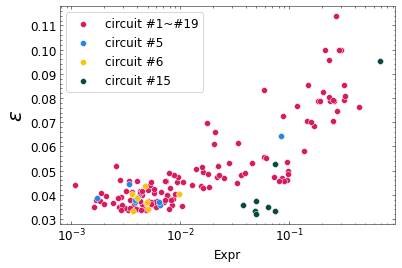

In [123]:
import seaborn as sns

plt.figure()
sns.scatterplot(data=data, x='expr', y='last_cost_avg', label='circuit #1~#19')
sns.scatterplot(data=data.loc[data['circuit_id']==5], x='expr', y='last_cost_avg', label='circuit #5')
sns.scatterplot(data=data.loc[data['circuit_id']==6], x='expr', y='last_cost_avg', label='circuit #6')
sns.scatterplot(data=data.loc[data['circuit_id']==15], x='expr', y='last_cost_avg', label='circuit #15')

plt.xscale('log')
plt.xlabel('Expr')
plt.ylabel(r'$\epsilon$', fontsize=20)
plt.legend()
plt.savefig('./figs/si_sum_epsilon_expr.pdf')

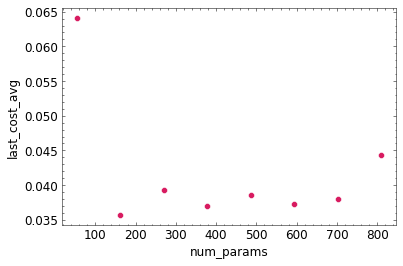

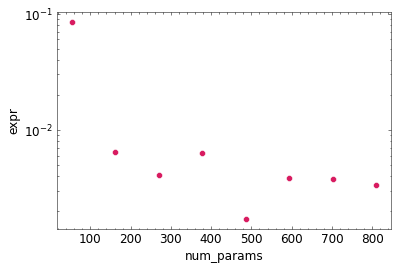

In [12]:
plt.figure()
sns.scatterplot(data=data[data['circuit_id']==5], x='num_params', y='last_cost_avg')
plt.figure()
sns.scatterplot(data=data[data['circuit_id']==5], x='num_params', y='expr')
plt.yscale('log')
#plt.xscale('log')

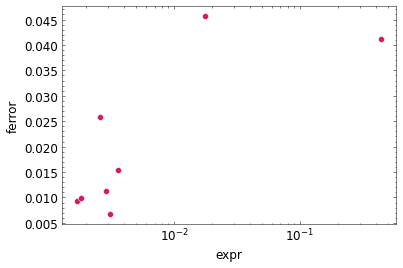

In [13]:
sns.scatterplot(data=data[data['circuit_id']==9], x='expr', y='ferror')
plt.xscale('log')


In [14]:
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
c3 = color_list[3]
c1 = color_list[0]
c2= color_list[4]

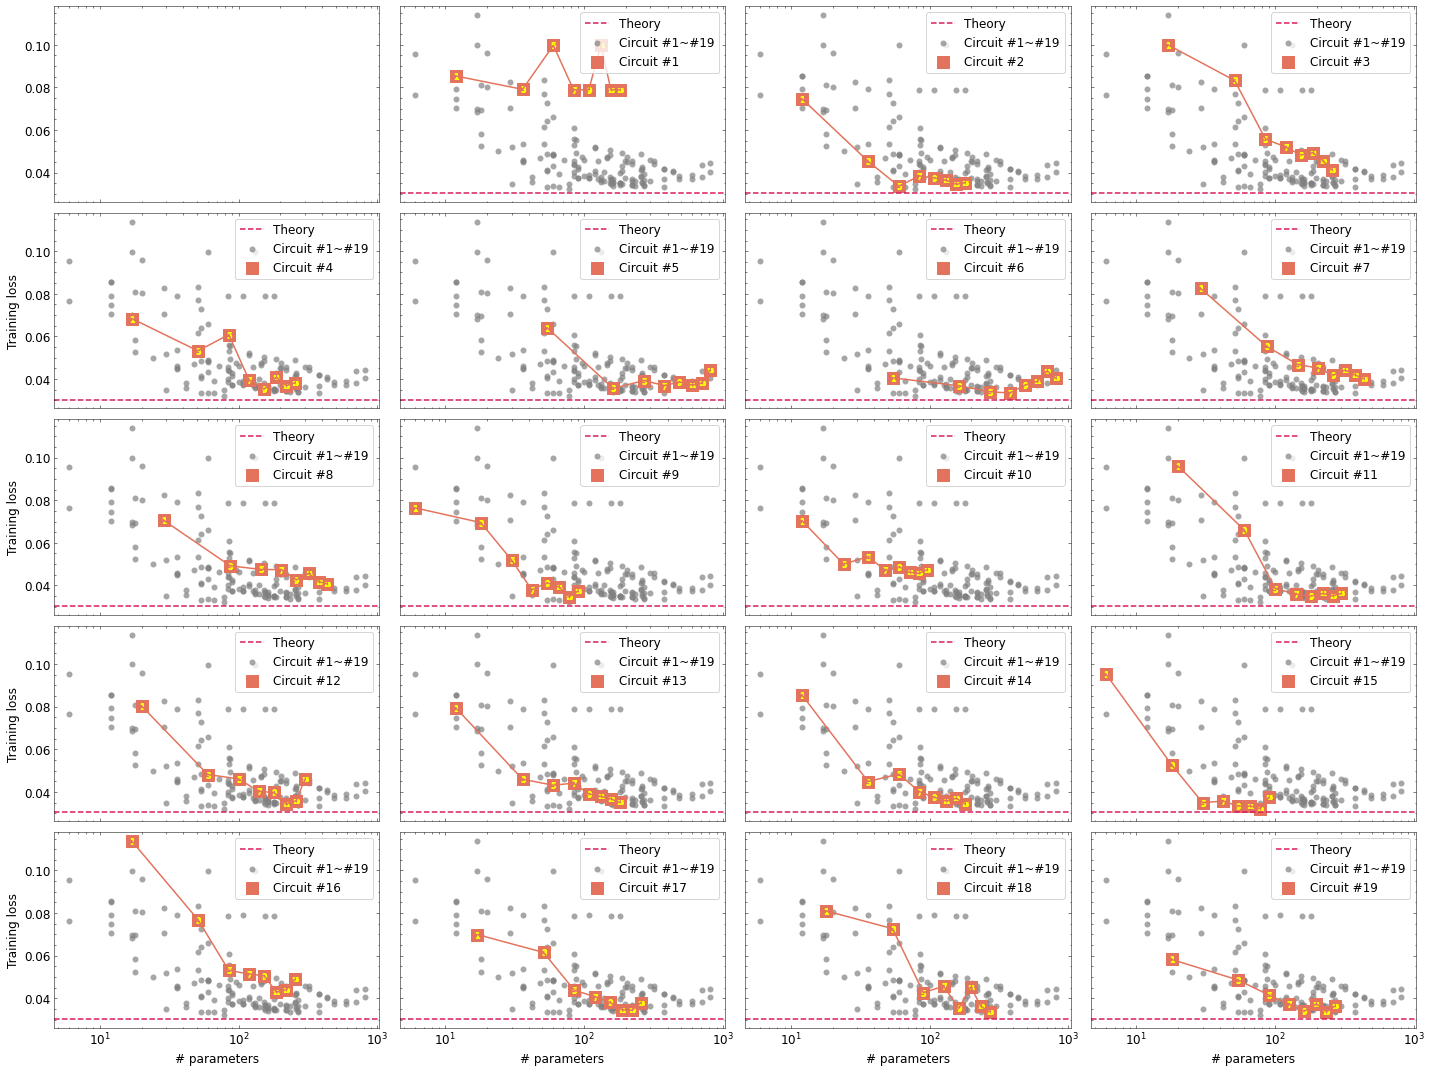

In [129]:
%matplotlib inline
fig, axes = plt.subplots(5, 4, figsize=(20, 15), squeeze=True, sharex=True, sharey=True)
for cid in _setting_qasvm["CIRCUIT_ID"]:
    ax = axes.flatten()[cid%20]
    not15 = data.loc[data['circuit_id']!=cid]
    yes15 = data.loc[data['circuit_id']==cid]
    ax.scatter(not15['num_params'], not15['last_cost_avg'], marker='o', color='grey', alpha=0.7, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
    ax.plot(yes15['num_params'], yes15['last_cost_avg'], marker='', color=c2)
    if cid<20:
        with plt.rc_context({'lines.markersize': 2*plt.rcParams['lines.markersize']}):
            ax.scatter(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=c2, label=f'Circuit #{cid}')
        for l in _setting_qasvm["LAYERS"]:
            ax.scatter(yes15.loc[yes15['layer']==l]['num_params'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
    ax.axhline(y=svm.dual_objective_value, linestyle='--', label='Theory', color=c1)
    ax.set_xscale('log')
    if cid%20 in [0, 4, 8, 12, 16]:
        ax.set_ylabel('Training loss')
    if cid%20 in [16, 17, 18, 19]:
        ax.set_xlabel('# parameters')
    ax.legend()
plt.tight_layout()
plt.savefig('./figs/si_num_param_vs_cost.pdf')
plt.show()

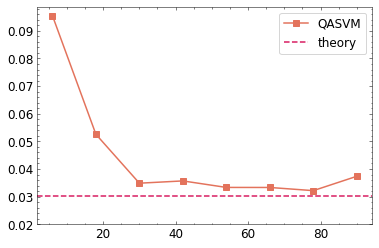

In [16]:
fig, ax = plt.subplots()

yes15 = data.loc[data['circuit_id']==15]
ax.plot(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=c2, label='QASVM')

with plt.rc_context({'lines.markersize': plt.rcParams['lines.markersize']}):
    pass

ax.axhline(y=svm.dual_objective_value, linestyle='--', label='theory', color=c1)
# ax.axvline(x=64, linestyle='-')
ax.set_ylim((0.02, None))
# ax.set_xticks(yes15['num_params'])
ax.legend()


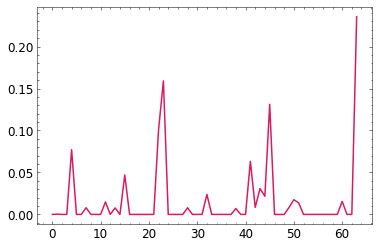

In [17]:
plt.plot(svm.alpha)

In [18]:
data[data['circuit_id']==15]

,dataset,circuit_id,layer,num_params,expr,entcap,num_iter,last_cost_avg,accuracy,ferror
112,0,15,1,6,0.681567,0.688292,1024,0.095499,0.953488,0.050549
113,0,15,3,18,0.074600,0.873500,1024,0.052563,0.941860,0.024042
114,0,15,5,30,0.063742,0.922488,1024,0.034871,0.941860,0.006840
115,0,15,7,42,0.037983,0.934545,1024,0.035696,0.941860,0.005582
116,0,15,9,54,0.048784,0.936672,1024,0.033342,0.953488,0.006612
117,0,15,11,66,0.073985,0.939771,1024,0.033324,0.941860,0.003552
118,0,15,13,78,0.049637,0.938985,1024,0.032178,0.953488,0.003006
119,0,15,15,90,0.049491,0.940458,1024,0.037368,0.953488,0.006910


In [19]:
from classifiers.quantum.ansatz import PQC_Properties, sample_circuit
from tqdm import tqdm
expr_list = []
for i in tqdm([1, 3, 5, 7, 9, 11, 15]):
    expr_list.append(PQC_Properties(sample_circuit(15)(7, i)).expressibility(num_samples=2**3))

100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


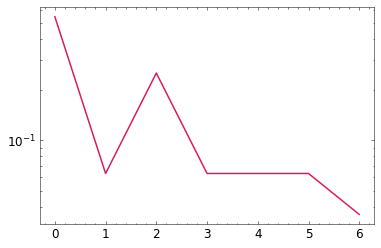

In [20]:
plt.plot(expr_list)
plt.yscale('log')

In [21]:
path_32 = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking(32)")
path_64 = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking")
path_128 = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking(128)")
path_256 = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking(256)")
path_512 = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking(512)")

training_data_32 = np.load(path_32/'Dataset #0/training_data.npy')
test_data_32 = np.load(path_32/'Dataset #0/test_data.npy')
training_label_32 = np.load(path_32/'Dataset #0/training_label.npy')
test_label_32 = np.load(path_32/'Dataset #0/test_label.npy')

training_data_64 = np.load(path_64/'Dataset #0/training_data.npy')
test_data_64 = np.load(path_64/'Dataset #0/test_data.npy')
training_label_64 = np.load(path_64/'Dataset #0/training_label.npy')
test_label_64 = np.load(path_64/'Dataset #0/test_label.npy')

training_data_128 = np.load(path_128/'Dataset #0/training_data.npy')
test_data_128 = np.load(path_128/'Dataset #0/test_data.npy')
training_label_128 = np.load(path_128/'Dataset #0/training_label.npy')
test_label_128 = np.load(path_128/'Dataset #0/test_label.npy')

training_data_256 = np.load(path_256/'Dataset #0/training_data.npy')
test_data_256 = np.load(path_256/'Dataset #0/test_data.npy')
training_label_256 = np.load(path_256/'Dataset #0/training_label.npy')
test_label_256 = np.load(path_256/'Dataset #0/test_label.npy')

training_data_512 = np.load(path_512/'Dataset #0/training_data.npy')
test_data_512 = np.load(path_512/'Dataset #0/test_data.npy')
training_label_512 = np.load(path_512/'Dataset #0/training_label.npy')
test_label_512 = np.load(path_512/'Dataset #0/test_label.npy')

data_32 = read_csv(path_32/'sample_summary.csv')
data_64 = read_csv(path_64/'sample_summary.csv')
data_128 = read_csv(path_128/'sample_summary.csv')
data_256 = read_csv(path_256/'sample_summary.csv')
data_512 = read_csv(path_512/'sample_summary.csv')

In [22]:
with open(path_32/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm_32 = dill.load(fp)

training_kernel_32 = _qasvm_32.kernel_matrix
test_kernel_32 = _qasvm_32._qk.evaluate(test_data_32, training_data_32)

svm_32 = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm_32.fit(training_kernel_32, training_label_32)
true_f_32 = svm_32.f(test_kernel_32)


with open(path_64/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm_64 = dill.load(fp)

training_kernel_64 = _qasvm_64.kernel_matrix
test_kernel_64 = _qasvm_64._qk.evaluate(test_data_64, training_data_64)

svm_64 = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm_64.fit(training_kernel_64, training_label_64)
true_f_64 = svm_64.f(test_kernel_64)

with open(path_128/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm_128 = dill.load(fp)

training_kernel_128 = _qasvm_128.kernel_matrix
test_kernel_128 = _qasvm_128._qk.evaluate(test_data_128, training_data_128)

svm_128 = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm_128.fit(training_kernel_128, training_label_128)
true_f_128 = svm_128.f(test_kernel_128)

with open(path_256/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm_256 = dill.load(fp)

training_kernel_256 = _qasvm_256.kernel_matrix
test_kernel_256 = _qasvm_256._qk.evaluate(test_data_256, training_data_256)

svm_256 = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm_256.fit(training_kernel_256, training_label_256)
true_f_256 = svm_256.f(test_kernel_256)

with open(path_512/f"Dataset #{0}/Circuit #{15}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm_512 = dill.load(fp)

training_kernel_512 = _qasvm_512.kernel_matrix
test_kernel_512 = _qasvm_512._qk.evaluate(test_data_512, training_data_512)

svm_512 = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm_512.fit(training_kernel_512, training_label_512)
true_f_512 = svm_512.f(test_kernel_512)

In [23]:
from itertools import product
from pandas import DataFrame

def fval_32(did, cid, layer, reps):
    with open(path_32/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

def fval_error_32(*args):
    return np.mean(np.abs(fval_32(*args)-true_f_32))# /sum(np.abs(true_f))

fval_error_32_ = {}
for _ind, _exp in enumerate(data_32.iloc):
    fval_error_32_[_ind] = fval_error_32(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data_32 = data_32.to_dict()
new_data_32['ferror'] = fval_error_32_
data_32 = DataFrame(new_data_32)


def fval_64(did, cid, layer, reps):
    with open(path_64/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

def fval_error_64(*args):
    return np.mean(np.abs(fval_64(*args)-true_f_64))# /sum(np.abs(true_f))

fval_error_64_ = {}
for _ind, _exp in enumerate(data_64.iloc):
    fval_error_64_[_ind] = fval_error_64(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data_64 = data_64.to_dict()
new_data_64['ferror'] = fval_error_64_
data_64 = DataFrame(new_data_64)


def fval_128(did, cid, layer, reps):
    with open(path_128/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

def fval_error_128(*args):
    return np.mean(np.abs(fval_128(*args)-true_f_128))# /sum(np.abs(true_f))

fval_error_128_ = {}
for _ind, _exp in enumerate(data_128.iloc):
    fval_error_128_[_ind] = fval_error_128(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data_128 = data_128.to_dict()
new_data_128['ferror'] = fval_error_128_
data_128 = DataFrame(new_data_128)


def fval_256(did, cid, layer, reps):
    with open(path_256/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

def fval_error_256(*args):
    return np.mean(np.abs(fval_256(*args)-true_f_256))# /sum(np.abs(true_f))

fval_error_256_ = {}
for _ind, _exp in enumerate(data_256.iloc):
    fval_error_256_[_ind] = fval_error_256(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data_256 = data_256.to_dict()
new_data_256['ferror'] = fval_error_256_
data_256 = DataFrame(new_data_256)


def fval_512(did, cid, layer, reps):
    with open(path_512/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

def fval_error_512(*args):
    return np.mean(np.abs(fval_512(*args)-true_f_512))# /sum(np.abs(true_f))

fval_error_512_ = {}
for _ind, _exp in enumerate(data_512.iloc):
    fval_error_512_[_ind] = fval_error_512(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data_512 = data_512.to_dict()
new_data_512['ferror'] = fval_error_512_
data_512 = DataFrame(new_data_512)

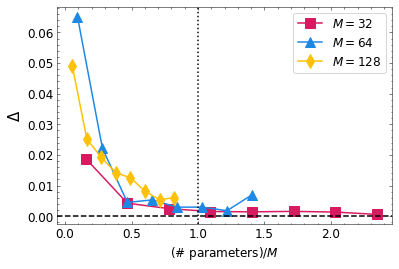

In [131]:
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':10}):
    fig, ax = plt.subplots()
    yes15_32 = data_32.loc[data_32['circuit_id']==15]
    ax.plot(yes15_32['num_params']/len(training_label_32), yes15_32['last_cost_avg']-svm_32.dual_objective_value, marker='s', label=r'$M=32$')
    yes15_64 = data_64.loc[data_64['circuit_id']==15]
    ax.plot(yes15_64['num_params']/len(training_label_64), yes15_64['last_cost_avg']-svm_64.dual_objective_value, marker='^', label=r'$M=64$')
    yes15_128 = data_128.loc[data_128['circuit_id']==15]
    ax.plot(yes15_128['num_params']/len(training_label_128), yes15_128['last_cost_avg']-svm_128.dual_objective_value, marker='d', label=r'$M=128$')
    # yes15_256 = data_256.loc[data_256['circuit_id']==15]
    # ax.plot(yes15_256['num_params']/len(training_label_256), yes15_256['last_cost_avg']-svm_256.dual_objective_value, marker='o', label=r'$M=256$')
    # yes15_512 = data_512.loc[data_512['circuit_id']==15]
    # ax.plot(yes15_512['num_params']/len(training_label_512), yes15_512['last_cost_avg']-svm_512.dual_objective_value, marker='x', label=r'$M=512$')


    ax.axhline(y=0, linestyle='--', color='k')
    ax.axvline(x=1, linestyle='dotted', color='k')
    # ax.axvline(x=64, linestyle='-')
    # ax.set_ylim((0.02, None))
    # ax.set_xticks(yes15_64['layer'])
    ax.legend()
    #ax.set_ylim([None, 1])
    ax.set_xlabel(r'(# parameters)/$M$')
    ax.set_ylabel(r'$\Delta$', fontsize=1.5*plt.rcParams['font.size'])
    # ax.set_ylabel('Training loss difference')
    # ax.set_yscale('log')

# fig.savefig('./figs/numerical_analysis_iris_last_cost.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_iris_last_cost.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_iris_last_cost.pdf', dpi=300)

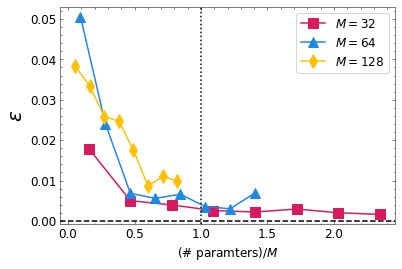

In [65]:
with plt.rc_context(rc={'figure.figsize':(6, 4), 'lines.markersize':10}):
    fig, ax = plt.subplots()

    yes15_32 = data_32.loc[data_32['circuit_id']==15]
    ax.plot(yes15_32['num_params']/len(training_label_32), yes15_32['ferror'], marker='s', label=r'$M=32$')
    yes15_64 = data_64.loc[data_64['circuit_id']==15]
    ax.plot(yes15_64['num_params']/len(training_label_64), yes15_64['ferror'], marker='^', label=r'$M=64$')
    yes15_128 = data_128.loc[data_128['circuit_id']==15]
    ax.plot(yes15_128['num_params']/len(training_label_128), yes15_128['ferror'], marker='d', label=r'$M=128$')
    # yes15_256 = data_256.loc[data_256['circuit_id']==15]
    # ax.plot(yes15_256['num_params']/len(training_label_256), yes15_256['ferror'], marker='s', label=r'$M=256$')
    # yes15_512 = data_512.loc[data_512['circuit_id']==15]
    # ax.plot(yes15_512['num_params']/len(training_label_512), yes15_512['ferror'], marker='s', label=r'$M=512$')


    ax.axhline(y=0, linestyle='--', color='k')
    ax.axvline(x=1, linestyle='dotted', color='k')
    ax.legend()
    ax.set_xlabel(r'(# paramters)/$M$')
    # ax.set_ylabel(r'$\epsilon$', fontsize=2*plt.rcParams['font.size'])
    ax.set_ylabel(r'$\epsilon$', fontsize=2*plt.rcParams['font.size'])
    # ax.set_yscale('log')
    
# fig.savefig('./figs/numerical_analysis_iris_error.svg', dpi=300)
# fig.savefig('./figs/numerical_analysis_iris_error.png', dpi=300)
# fig.savefig('./figs/numerical_analysis_iris_error.pdf', dpi=300)

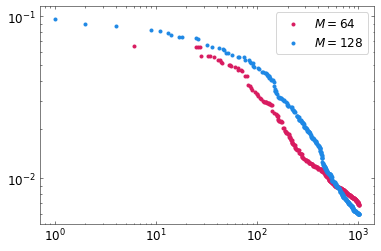

In [81]:
import dill
fig, ax = plt.subplots()

with open(path_64/'Dataset #0/Circuit #15/layer=15/0/storage', 'rb') as fp:
    storage_64 = dill.load(fp)

with open(path_128/'Dataset #0/Circuit #15/layer=15/0/storage', 'rb') as fp:
    storage_128 = dill.load(fp)

opt_64 = storage_64.data[storage_64.data['Accepted']==True]
ax.scatter(opt_64['Step'], opt_64['Cost']-svm_64.dual_objective_value, marker='.', label='$M=64$')
opt_128 = storage_128.data[storage_128.data['Accepted']==True]
ax.scatter(opt_128['Step'], opt_128['Cost']-svm_128.dual_objective_value, marker='.', label='$M=128$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_xscale('log')

(100, 1397.3909156758646)

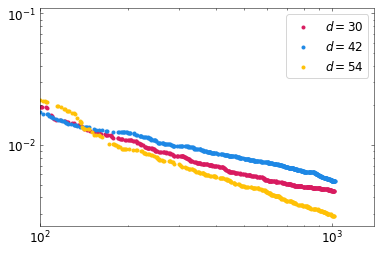

In [82]:
import dill
fig, ax = plt.subplots()

with open(path_64/'Dataset #0/Circuit #15/layer=5/0/storage', 'rb') as fp:
    storage_32 = dill.load(fp)

with open(path_64/'Dataset #0/Circuit #15/layer=7/0/storage', 'rb') as fp:
    storage_64 = dill.load(fp)

with open(path_64/'Dataset #0/Circuit #15/layer=9/0/storage', 'rb') as fp:
    storage_128 = dill.load(fp)


opt_32 = storage_32.data[storage_32.data['Accepted']==True]
ax.scatter(opt_32['Step'], opt_32['Cost']-svm_64.dual_objective_value, marker='.', label='$d=30$')
opt_64 = storage_64.data[storage_64.data['Accepted']==True]
ax.scatter(opt_64['Step'], opt_64['Cost']-svm_64.dual_objective_value, marker='.', label='$d=42$')
opt_128 = storage_128.data[storage_128.data['Accepted']==True]
ax.scatter(opt_128['Step'], opt_128['Cost']-svm_64.dual_objective_value, marker='.', label='$d=54$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlim([100, None])
# ax.set_xscale('log')

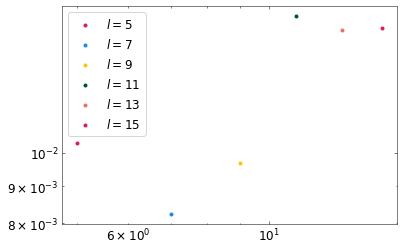

In [57]:
import dill
fig, ax = plt.subplots()

for l in _setting_qasvm['LAYERS'][2:]:
    with open(path_512/f'Dataset #0/Circuit #15/layer={l}/0/storage', 'rb') as fp:
        storage_ = dill.load(fp)

    opt_ = storage_.data[storage_.data['Accepted']==True]
    ax.scatter(l, list(opt_['Cost']-svm_128.dual_objective_value)[-1], marker='.', label=f'$l={l}$')
    ax.set_yscale('log')
    ax.set_xscale('log')
ax.legend()

No handles with labels found to put in legend.


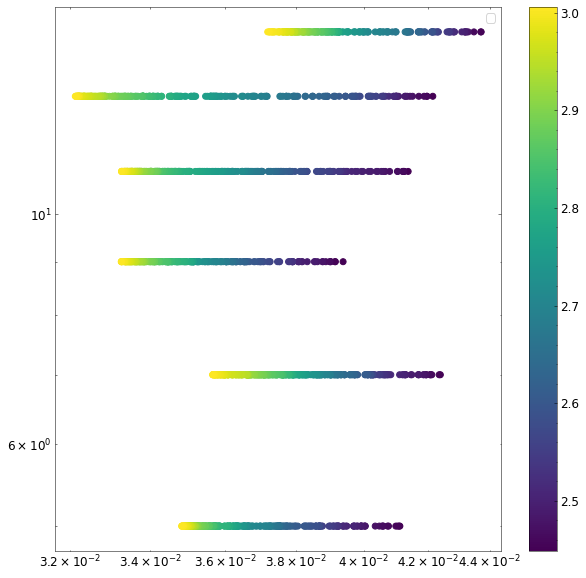

In [93]:
import dill
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for l in _setting_qasvm['LAYERS'][2:]:
    with open(path_64/f'Dataset #0/Circuit #15/layer={l}/0/storage', 'rb') as fp:
        storage_ = dill.load(fp)

    opt_ = storage_.data[storage_.data['Accepted']==True]
    cs = ax.scatter(opt_['Cost'][100:], l*np.ones(len(opt_)-100), c=np.log10(opt_['Step'][100:]))
    ax.set_yscale('log')
    ax.set_xscale('log')
ax.legend()
fig.colorbar(cs)

In [28]:
with open(path_64/'Dataset #0/Circuit #15/layer=5/0/qasvm', 'rb') as fp:
    qasvm = dill.load(fp)
with open(path_64/'Dataset #0/Circuit #15/layer=5/0/storage', 'rb') as fp:
    storage = dill.load(fp)

storage_data = storage.data.copy()
ferror = {}
for ind, step_data in enumerate(tqdm(storage_data.iloc, total=len(storage))):
    if ind%100==0:
        qasvm.parameters = np.array(step_data[2:-3])
        fvec = qasvm.accuracy(test_data_64, test_label_64)#f(test_data_64)
        ferror[ind] = fvec#np.mean(np.abs(fvec-true_f_64))
    else:
        ferror[ind] = np.inf

new_storage_data = storage_data.to_dict()
new_storage_data['ferror'] = ferror
storage_data = DataFrame(new_storage_data)

100%|██████████| 1024/1024 [00:12<00:00, 81.56it/s]


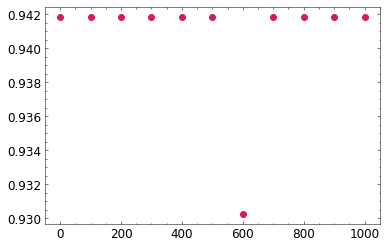

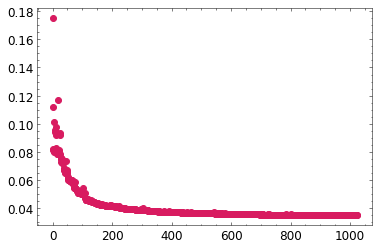

In [29]:
plt.scatter(storage_data['Step'], storage_data['ferror'])
plt.figure()
plt.scatter(storage.data['Step'], storage.data['Cost'])


In [30]:
storage_data

,Step,# Func. Eval.,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,Cost,Step Size,Accepted,ferror
0,0,4,0.330965,3.555899,-3.239993,-1.152662,0.043101,-0.157929,4.055712,0.042086,...,1.166272,-3.125716,0.914340,3.408252,1.757490,-4.409521,0.111737,9.247634,False,0.94186
1,1,7,2.868992,2.717166,-0.701967,-1.991394,2.581128,0.680803,3.216979,0.880819,...,2.005004,-0.587690,1.753072,0.870226,0.918757,-3.570789,0.175371,4.653708,False,inf
2,2,10,1.937157,1.949707,-1.633802,-2.923229,1.649293,1.448262,2.449520,1.812654,...,2.772463,-1.519525,2.520531,1.802061,-0.013078,-2.803330,0.081645,0.450162,False,inf
3,3,13,1.806560,2.080304,-1.338829,-3.053826,1.944265,1.317666,2.580117,1.517681,...,3.067436,-1.650121,2.815504,1.932657,-0.143675,-2.933927,0.082005,1.165470,False,inf
4,4,16,2.390645,2.238820,-1.922914,-2.469740,2.102781,1.159150,1.996032,1.359165,...,2.483351,-1.808637,2.231419,1.348572,0.440411,-2.349842,0.101226,2.033696,False,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1019,3061,2.505040,1.902502,-0.870366,-2.554822,2.172561,1.292781,0.898383,0.899331,...,2.053661,-1.906769,2.765544,1.520880,-0.094157,-2.965974,0.034842,0.032301,False,inf
1020,1020,3064,2.499591,1.897053,-0.875815,-2.560271,2.178010,1.287333,0.903832,0.904779,...,2.047315,-1.913115,2.759199,1.514535,-0.100503,-2.972320,0.034828,0.002456,True,inf
1021,1021,3067,2.501587,1.899049,-0.873819,-2.558275,2.176014,1.289328,0.905828,0.902784,...,2.049311,-1.911119,2.761194,1.512539,-0.098507,-2.970324,0.034828,0.010932,False,inf
1022,1022,3070,2.502390,1.894254,-0.873016,-2.563070,2.175211,1.284534,0.906631,0.907578,...,2.044517,-1.915913,2.756400,1.517333,-0.097704,-2.969521,0.034832,0.015329,False,inf
